In [ ]:
#default_exp noisyimagenette

In [ ]:
#hide
!pip install nbdev -q --upgrade
!pip install fastai -q --upgrade

     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 194kB 18.5MB/s 
     |████████████████████████████████| 12.8MB 202kB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
!pip install wwf -q --upgrade
!pip install cleanlab -q --upgrade

     |████████████████████████████████| 296kB 16.7MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 


In [ ]:
from fastcore.test import *

import fastai, fastcore, nbdev
test_eq(['2.3.0', '1.3.19', '1.1.14'], [fastai.__version__, fastcore.__version__, nbdev.__version__])

In [ ]:
#export 
from fastai.vision.all import *
from pathlib import Path

import pandas as pd

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
source = untar_data(URLs.IMAGENETTE)
df: pd.DataFrame = pd.read_csv(source/'noisy_imagenette.csv')

In [ ]:
train_df = df[df.is_valid == False]

In [ ]:
len(train_df)

9469

In [ ]:
test_eq(13394, len(df))
expected = ['path', 'noisy_labels_0', 'noisy_labels_1', 'noisy_labels_5', 'noisy_labels_25', 'noisy_labels_50', 'is_valid']

test_eq(expected, list(df))
test_eq(3925, len(df[df['is_valid'] == True]))

In [ ]:
sample = dict(
    is_valid=False,
    noisy_labels_0='n02979186',
    noisy_labels_1='n02979186',
    noisy_labels_25='n02979186',
    noisy_labels_5='n02979186',
    noisy_labels_50='n02979186',
    path='train/n02979186/n02979186_9036.JPEG')

test_eq(sample, dict(df.iloc[0]))

In [ ]:
#export
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
lbl_dict_inv = {v: k for k, v in lbl_dict.items()}
def get_inverse_transform(vocab):
  return L(vocab).map(lbl_dict_inv)

In [ ]:
#export
set_seed(42, reproducible=True)

In [ ]:
#export
def get_dls(file, noice_pct=5, size=128, soft_targets=False):

  if soft_targets:
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_x=ColReader('path', pref=source),
                    get_y=Pipeline([ColReader(f'soft_targets'), lbl_dict.__getitem__]),
                    splitter=ColSplitter(), #uses the bool value in is_valid column on the dataframe to identify the validation set (without any noise).
                    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                    batch_tfms=Normalize.from_stats(*imagenet_stats))

  else: 
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_x=ColReader('path', pref=source),
                    get_y=Pipeline([ColReader(f'noisy_labels_{noice_pct}'), lbl_dict.__getitem__]),
                    splitter=ColSplitter(), #uses the bool value in is_valid column on the dataframe to identify the validation set (without any noise).
                    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                    batch_tfms=Normalize.from_stats(*imagenet_stats))
  dls = dblock.dataloaders(file)
  return dls

## 5 noice percent

In [ ]:
#export
dls_5 = get_dls(df, 5, size=224)

In [ ]:
b = dls_5.one_batch();
test_eq(2, len(b)) 
test_eq([64, 3, 224, 224], b[0].shape)
test_eq([64], b[1].shape)

In [ ]:
expected = ['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']

test_eq(expected, dls_5.valid.vocab)

In [ ]:
len(dls_5.train_ds), len(dls_5.valid_ds)

(9469, 3925)

In [ ]:
x = dls_5.train_ds[0]; x

(PILImage mode=RGB size=500x375, TensorCategory(2))

In [ ]:
dls_5.train.after_item

Pipeline: FlipItem -- {'p': 0.5} -> RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor

In [ ]:
dls_5.train.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

In [ ]:
for f in dls_5.train.after_item:
  name = f.name
  x = f(x)
  print(name, x[0]) 

FlipItem -- {'p': 0.5} PILImage mode=RGB size=500x375
RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} PILImage mode=RGB size=224x224
ToTensor TensorImage([[[134, 149, 167,  ..., 131, 133, 131],
         [134, 153, 179,  ..., 133, 128, 131],
         [145, 160, 179,  ..., 135, 134, 131],
         ...,
         [215, 212, 210,  ..., 247, 251, 254],
         [216, 217, 215,  ..., 251, 254, 254],
         [217, 220, 222,  ..., 250, 252, 251]],

        [[134, 149, 167,  ..., 131, 133, 131],
         [134, 153, 179,  ..., 133, 128, 131],
         [145, 160, 179,  ..., 135, 134, 131],
         ...,
         [215, 212, 210,  ..., 211, 212, 219],
         [216, 217, 215,  ..., 213, 215, 218],
         [217, 220, 222,  ..., 213, 215, 218]],

        [[134, 149, 167,  ..., 131, 133, 131],
         [134, 153, 179,  ..., 133, 128, 131],
         [145, 160, 179,  ..., 135, 134, 131],

In [ ]:
x[0].shape

torch.Size([3, 224, 224])

In [ ]:
for f in dls_5.train.after_batch:
  name = f.name
  x = f(to_device(x, 'cuda')) #move the data to GPU
  print(name, x[0])

IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} TensorImage([[[0.5255, 0.5843, 0.6549,  ..., 0.5137, 0.5216, 0.5137],
         [0.5255, 0.6000, 0.7020,  ..., 0.5216, 0.5020, 0.5137],
         [0.5686, 0.6275, 0.7020,  ..., 0.5294, 0.5255, 0.5137],
         ...,
         [0.8431, 0.8314, 0.8235,  ..., 0.9686, 0.9843, 0.9961],
         [0.8471, 0.8510, 0.8431,  ..., 0.9843, 0.9961, 0.9961],
         [0.8510, 0.8627, 0.8706,  ..., 0.9804, 0.9882, 0.9843]],

        [[0.5255, 0.5843, 0.6549,  ..., 0.5137, 0.5216, 0.5137],
         [0.5255, 0.6000, 0.7020,  ..., 0.5216, 0.5020, 0.5137],
         [0.5686, 0.6275, 0.7020,  ..., 0.5294, 0.5255, 0.5137],
         ...,
         [0.8431, 0.8314, 0.8235,  ..., 0.8275, 0.8314, 0.8588],
         [0.8471, 0.8510, 0.8431,  ..., 0.8353, 0.8431, 0.8549],
         [0.8510, 0.8627, 0.8706,  ..., 0.8353, 0.8431, 0.8549]],

        [[0.5255, 0.5843, 0.6549,  ..., 0.5137, 0.5216, 0.5137],
         [0.5255, 0.6000, 0.7020,  ..., 0.5216, 0.5020, 0.5137],
   

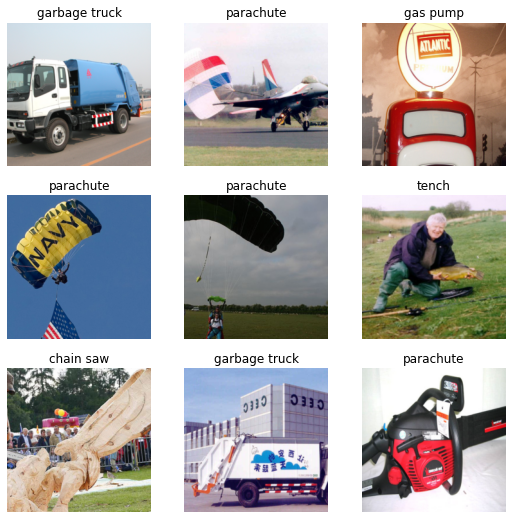

In [ ]:
dls_5.show_batch()

In [ ]:
#export
learn_5 = cnn_learner(dls_5, resnet18, metrics=[accuracy, RocAuc()])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0010000000474974513)

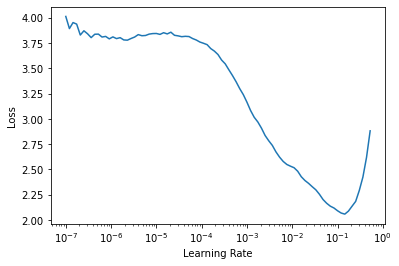

In [ ]:
learn_5.lr_find()

In [ ]:
# Reference: https://walkwithfastai.com/EfficientNet_and_Custom_Weights
# #fastai model can split into layer groups 
# Group 1 -> Encoder ie everything by the last layer of original model
# Group 2 -> Head ie Linear + additional

learn_5.model[-1] #head 

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [ ]:
show_doc(Learner.fine_tune)

<h4 id="Learner.fine_tune" class="doc_header"><code>Learner.fine_tune</code><a href="https://github.com/fastai/fastai/tree/master/fastai/callback/schedule.py#L151" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fine_tune</code>(**`epochs`**, **`base_lr`**=*`0.002`*, **`freeze_epochs`**=*`1`*, **`lr_mult`**=*`100`*, **`pct_start`**=*`0.3`*, **`div`**=*`5.0`*, **`lr_max`**=*`None`*, **`div_final`**=*`100000.0`*, **`wd`**=*`None`*, **`moms`**=*`None`*, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR

In [ ]:
#export
learn_5.fine_tune(epochs=5, base_lr=1e-3, freeze_epochs=3)

In [ ]:
#export
learn_5.save('learn_5')

Path('models/learn_5.pth')

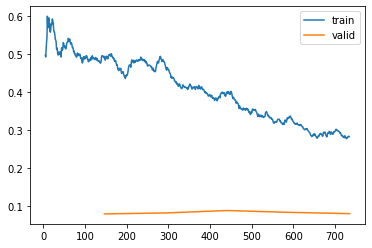

In [ ]:
learn_5.recorder.plot_loss()

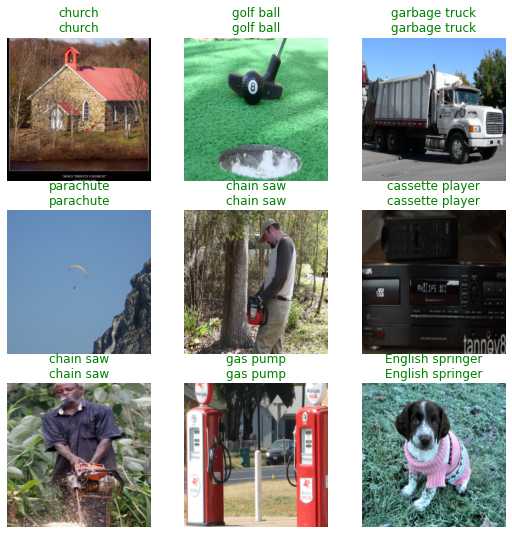

In [ ]:
learn_5.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_5)
interp.most_confused()

[('garbage truck', 'gas pump', 5),
 ('chain saw', 'French horn', 4),
 ('chain saw', 'garbage truck', 4),
 ('French horn', 'chain saw', 3),
 ('cassette player', 'chain saw', 3),
 ('gas pump', 'chain saw', 3),
 ('parachute', 'church', 3),
 ('cassette player', 'garbage truck', 2),
 ('chain saw', 'church', 2),
 ('chain saw', 'gas pump', 2),
 ('garbage truck', 'chain saw', 2),
 ('gas pump', 'cassette player', 2),
 ('golf ball', 'parachute', 2),
 ('golf ball', 'tench', 2),
 ('parachute', 'French horn', 2),
 ('parachute', 'tench', 2),
 ('tench', 'chain saw', 2),
 ('French horn', 'cassette player', 1),
 ('French horn', 'garbage truck', 1),
 ('French horn', 'gas pump', 1),
 ('French horn', 'parachute', 1),
 ('French horn', 'tench', 1),
 ('cassette player', 'gas pump', 1),
 ('chain saw', 'English springer', 1),
 ('chain saw', 'cassette player', 1),
 ('chain saw', 'parachute', 1),
 ('church', 'garbage truck', 1),
 ('church', 'gas pump', 1),
 ('garbage truck', 'church', 1),
 ('gas pump', 'church',

In [ ]:
top_k, idxs = interp.top_losses(k=10)

In [ ]:
idxs

TensorBase([2315, 2904, 1967, 3023,  145, 2792,  528, 2737, 2764, 2765])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f85b2195dd0>, TensorCategory(9))

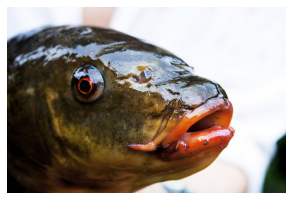

In [ ]:
dls_5.train_ds[2315][0].show(), dls_5.train_ds[2315][1]

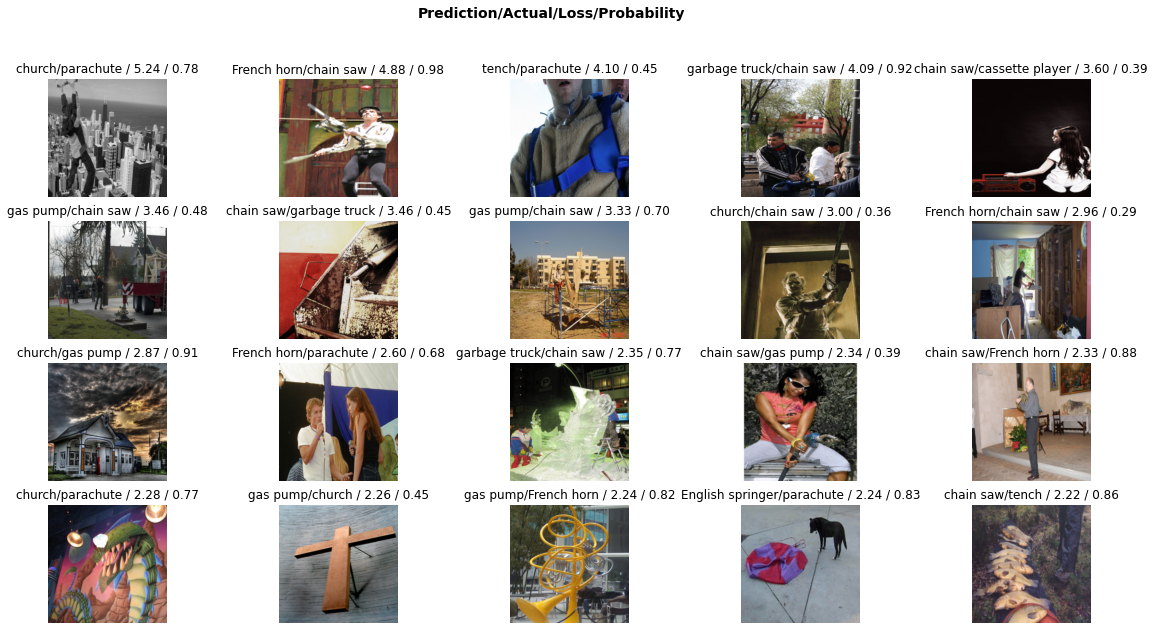

In [ ]:
interp.plot_top_losses(k=20, figsize=(20, 10))

### Get predictions for train and val dataloads

In [ ]:
#export
train_preds = learn_5.get_preds(ds_idx=0, with_decoded=True)

In [ ]:
train_preds

(tensor([[1.3731e-03, 1.3300e-03, 9.8152e-01,  ..., 1.0056e-03, 1.1169e-03,
          2.9588e-03],
         [3.6503e-03, 9.5305e-03, 8.1537e-01,  ..., 6.8630e-03, 2.2071e-02,
          6.6028e-03],
         [1.9473e-04, 7.2536e-05, 9.9713e-01,  ..., 6.6373e-04, 4.2151e-05,
          3.2498e-04],
         ...,
         [4.1621e-03, 2.2294e-02, 1.1591e-02,  ..., 4.8723e-03, 5.8460e-04,
          1.2253e-02],
         [4.3534e-06, 1.1636e-06, 5.3802e-07,  ..., 3.1808e-07, 1.1023e-04,
          9.8159e-06],
         [2.9555e-02, 1.7212e-02, 3.8437e-02,  ..., 3.7789e-02, 6.3827e-03,
          3.4245e-02]]),
 TensorCategory([2, 2, 2,  ..., 6, 6, 6]),
 tensor([2, 2, 2,  ..., 6, 6, 6]))

In [ ]:
#export
val_preds = learn_5.get_preds(ds_idx=1, with_decoded=True)

## Cleanlab

In [ ]:
#hide
#!pip install cleanlab -q

In [ ]:
#export
from cleanlab.pruning import get_noise_indices

In [ ]:
#export
train_ordered_label_errors = get_noise_indices(s=train_preds[1].numpy(), #targets
                             psx=train_preds[0].numpy(),#predictions_prob
                             sorted_index_method='normalized_margin')

In [ ]:
#exporti
print("We found {} label errors.".format(len(train_ordered_label_errors))) 

We found 208 label errors.


In [ ]:
train_ordered_label_errors[:5]

array([5367, 7307, 3156, 8986, 7232])

In [ ]:
#export
noisy_train = train_df.loc[train_ordered_label_errors]

In [ ]:
test_eq(205, len(noisy_train[noisy_train.noisy_labels_0 != noisy_train.noisy_labels_5]))

In [ ]:
test_eq(3, len(noisy_train[noisy_train.noisy_labels_0 == noisy_train.noisy_labels_5]))
noisy_train[noisy_train.noisy_labels_0 == noisy_train.noisy_labels_5]

path  ... is_valid
2789  train/n01440764/n01440764_11063.JPEG  ...    False
8885  train/n03425413/n03425413_11029.JPEG  ...    False
1523   train/n03417042/n03417042_3679.JPEG  ...    False

[3 rows x 7 columns]

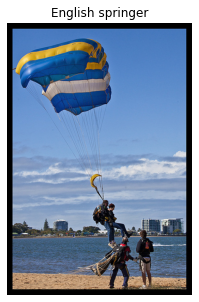

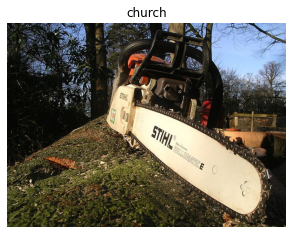

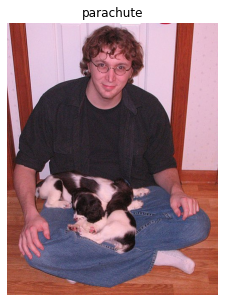

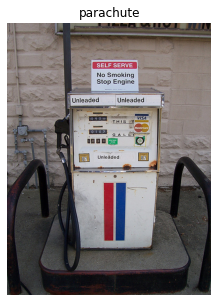

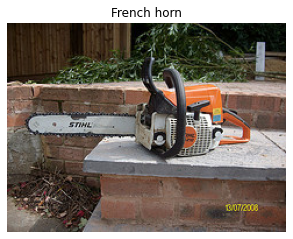

In [ ]:
for i in [5367, 7307, 3156, 8986, 7232]:
  show_at(dls_5.train.dataset, i)

Out of 208 indices reported as noisy, 205 are truly noisy and 3 are false positives (3 clean).

## 25 noice percent 

Here the validation set will not contain any incorrect labels.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('path', pref=source),
                   get_y=Pipeline([ColReader(f'noisy_labels_25'), lbl_dict.__getitem__]),
                   splitter=ColSplitter(),
                   item_tfms=[RandomResizedCrop(128, min_scale=0.35), FlipItem(0.5)],
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

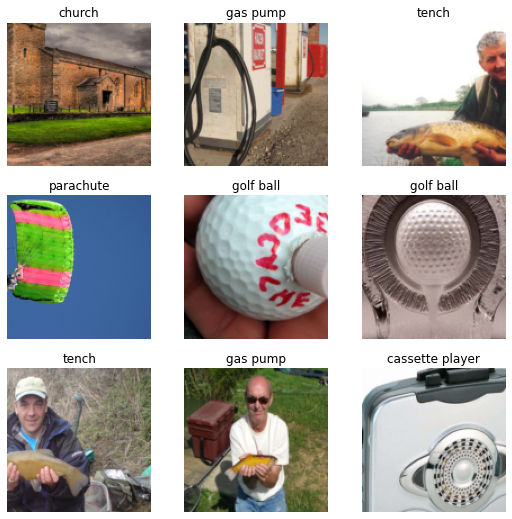

In [ ]:
dls = dblock.dataloaders(df)
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


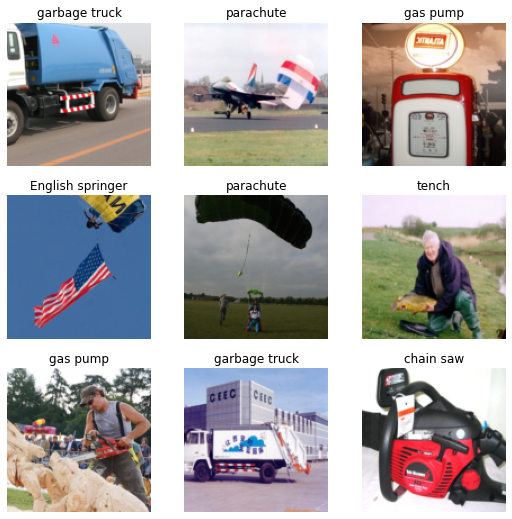

In [ ]:
dls.train.show_batch()

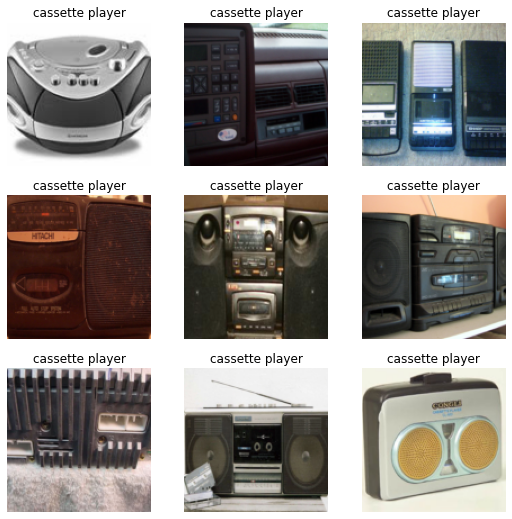

In [ ]:
dls.valid.show_batch()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0030199517495930195)

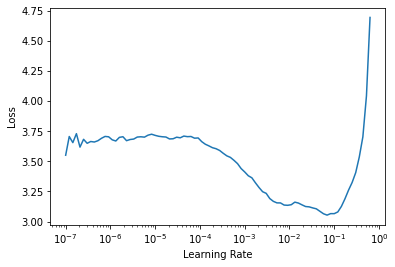

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-3)

KeyboardInterrupt: ignored

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=1.5848931980144698e-06)

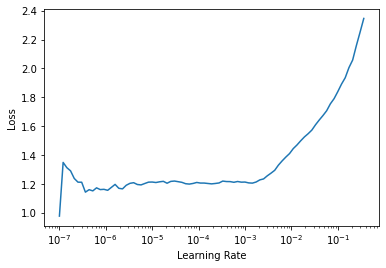

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6, 1e-3))

Even though our dataset has 25% incorrect labels present, we still managed to achieve 95% accuracy.

### Identify noisy labels on 25 synthetic noise percent.

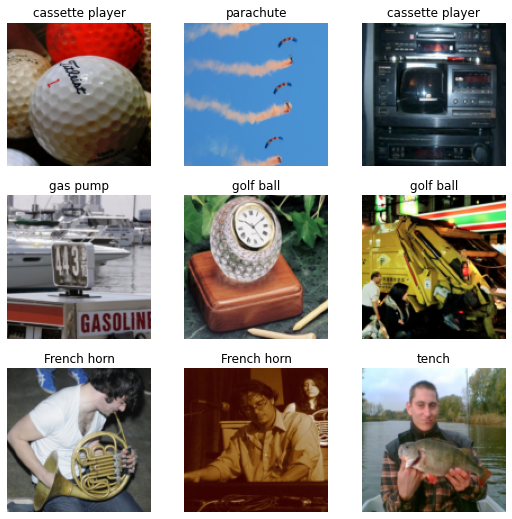

In [ ]:
dls_25 = get_dls(df, 25)
dls_25.show_batch()
learn_25 = cnn_learner(dls_25, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0010000000474974513)

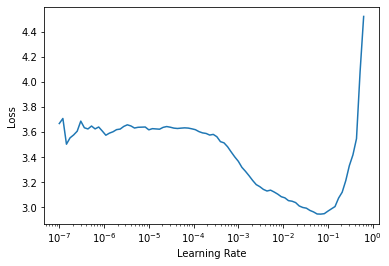

In [ ]:
learn_25.lr_find()

In [ ]:
learn_25.fine_tune(2, base_lr=1e-3, freeze_epochs=5)

We ended up at 94.9% accuracy even though our dataset contains 25% of noisy labels.

In [ ]:
from cleanlab.pruning import get_noise_indices
train_preds_25 = learn_25.get_preds(ds_idx=0, with_decoded=True) #Get the predictions from the training dataset (we do not know which one is a noisy label)
train_ordered_label_errors_25 = get_noise_indices(s=train_preds_25[1].numpy(), #targets
                                                  psx=train_preds_25[0].numpy(),#predictions_prob
                                                  sorted_index_method='normalized_margin')

In [ ]:
print(dls_25.vocab)
lbl_dict_inv = {v: k for k, v in lbl_dict.items()};lbl_dict_inv

['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']


{'English springer': 'n02102040',
 'French horn': 'n03394916',
 'cassette player': 'n02979186',
 'chain saw': 'n03000684',
 'church': 'n03028079',
 'garbage truck': 'n03417042',
 'gas pump': 'n03425413',
 'golf ball': 'n03445777',
 'parachute': 'n03888257',
 'tench': 'n01440764'}

In [ ]:
L(dls_25.vocab).map(lbl_dict_inv)

(#10) ['n02102040','n03394916','n02979186','n03000684','n03028079','n03417042','n03425413','n03445777','n03888257','n01440764']

In [ ]:
def get_inverse_transform(vocab):
  return L(vocab).map(lbl_dict_inv)

preds_25 = np.array(get_inverse_transform(L(list(train_preds_25[2])).map(dls_25.vocab)));type(preds_25)

numpy.ndarray

In [ ]:
train_df['predictions'] = preds_25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
confidence = torch.max(train_preds_25[0], axis=-1).values
train_df['confidence'] = confidence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['confidenceRange'] = pd.cut(train_df.confidence, bins=[0.0, 0.6, 0.8, 1.0], labels=['<60', '60-80', '80+'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
len(dls_25.train_ds), len(train_ordered_label_errors_25), round(len(train_ordered_label_errors_25)/len(dls_25.train_ds) , 2)

(9469, 2083, 0.22)

In [ ]:
print("We found {} label errors.".format(len(train_ordered_label_errors_25))) 

We found 2083 label errors.


Cleanlab detected 2080 samples as noisy labels from 9469 samples.

In [ ]:
noisy_train_25 = train_df.loc[train_ordered_label_errors_25]

In [ ]:
# Expected Noisy Labels 
(train_df.noisy_labels_0 != train_df.noisy_labels_25).sum()

2368

In [ ]:
expected = np.array(train_df[train_df.noisy_labels_0 != train_df.noisy_labels_25].index);expected
detected = np.array(sorted(train_ordered_label_errors_25));detected
len(set(expected) - set(detected)) #Missed 495 samples.

335

In [ ]:
# Actual Noisy Labels
(noisy_train_25.noisy_labels_0 != noisy_train_25.noisy_labels_25).sum()

2033

In [ ]:
noisy_train_25.confidenceRange.value_counts()

60-80    866
80+      834
<60      383
Name: confidenceRange, dtype: int64

Noisy Indices are ordered by the confidence, so the top ones would provide the most likely errors.   

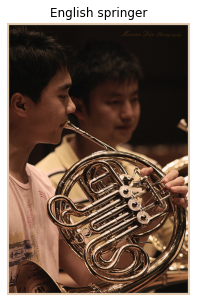

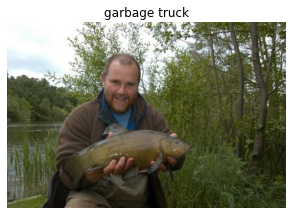

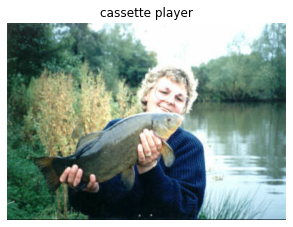

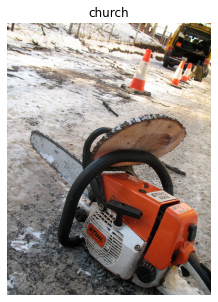

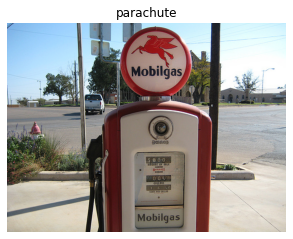

In [ ]:
for i in train_ordered_label_errors_25[:5]:
  show_at(dls_25.train.dataset, i)

We cannot remove all the noisy labels as the least confidence noisy indices seems are a hit or miss. For examples gas pump is labeled correctly for the last two images. 

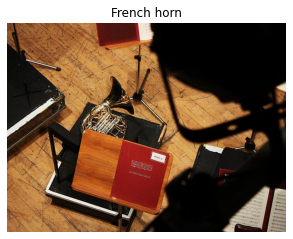

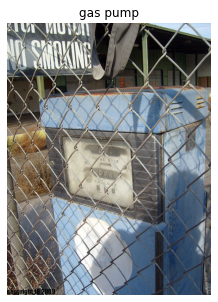

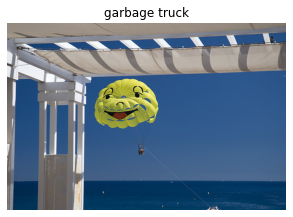

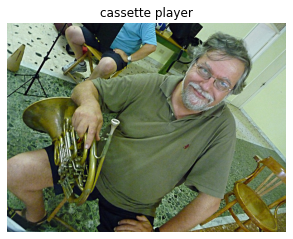

In [ ]:
for i in train_ordered_label_errors_25[-5:-1]:
  show_at(dls_25.train.dataset, i)

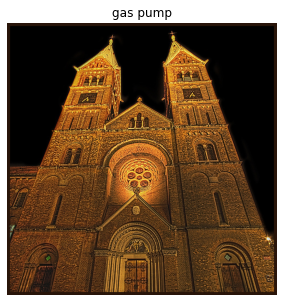

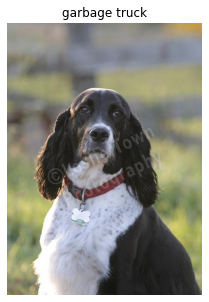

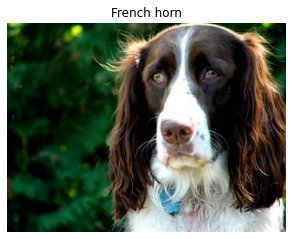

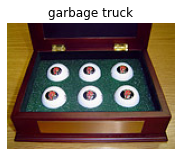

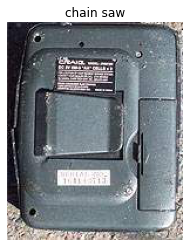

In [ ]:
for i in train_ordered_label_errors_25[1560:1565]:
  show_at(dls_25.train.dataset, i)

Instead of treating everything, let's prioritize and group them into 1. Highly Confident 2. Confident 3. Least Confident.

### Noisy Instances grouping based on Prediction Confidence 

In [ ]:
train_df.confidenceRange.value_counts()

80+      4890
60-80    2828
<60      1751
Name: confidenceRange, dtype: int64

In [ ]:
noisy_train_25.confidenceRange.value_counts()

60-80    866
80+      834
<60      383
Name: confidenceRange, dtype: int64

We use the predictions of samples from all the 80+ confidenceRange as the soft targets (pseudosamples) and retrain the model.

In [ ]:
train_df.loc[train_ordered_label_errors_25][train_df.confidenceRange == '80+']

In [ ]:
noisy_train_25[noisy_train_25.confidenceRange == '80+']['predictions']

In [ ]:
df['soft_targets'] = df['noisy_labels_25']

In [ ]:
len(preds_25), len(train_df.loc[train_ordered_label_errors_25][train_df.confidenceRange == '80+']), train_df.loc[train_ordered_label_errors_25][train_df.confidenceRange == '80+']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(9469, 834,                                       path  ... confidenceRange
 6688  train/n03394916/n03394916_72419.JPEG  ...             80+
 2725   train/n01440764/n01440764_3779.JPEG  ...             80+
 2718   train/n01440764/n01440764_9776.JPEG  ...             80+
 7156    train/n03000684/n03000684_368.JPEG  ...             80+
 9014   train/n03425413/n03425413_2814.JPEG  ...             80+
 ...                                    ...  ...             ...
 9144  train/n03425413/n03425413_14398.JPEG  ...             80+
 3409   train/n02102040/n02102040_3889.JPEG  ...             80+
 3029   train/n02102040/n02102040_7688.JPEG  ...             80+
 5806  train/n03394916/n03394916_27415.JPEG  ...             80+
 1200   train/n03417042/n03417042_1479.JPEG  ...             80+
 
 [834 rows x 11 columns])

In [ ]:
high_confident_noisy = train_df.loc[train_ordered_label_errors_25][train_df.confidenceRange == '80+'].index;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
high_confident_noisy

Int64Index([6688, 2725, 2718, 7156, 9014, 6988, 9344, 9177, 6379, 8534,
            ...
            6757,  657, 1150, 3425, 2837, 9144, 3409, 3029, 5806, 1200],
           dtype='int64', length=834)

In [ ]:
preds_25[6688]

'n03394916'

In [ ]:
# Changing the soft_targets value to the ones with high predictions on the identified noisy labels
for i, row in df.iterrows(): 
  if not row['is_valid'] and i in high_confident_noisy:
    pseudo = preds_25[i]
    df.at[i, 'soft_targets'] = pseudo

In [ ]:
df.iloc[6688]

path               train/n03394916/n03394916_72419.JPEG
noisy_labels_0                                n03394916
noisy_labels_1                                n03394916
noisy_labels_5                                n03394916
noisy_labels_25                               n02102040
noisy_labels_50                               n03000684
is_valid                                          False
soft_targets                                  n03394916
Name: 6688, dtype: object

In [ ]:
df.noisy_labels_25.value_counts()

n03888257    1409
n03425413    1361
n01440764    1358
n03417042    1351
n03445777    1350
n03394916    1344
n02102040    1325
n03028079    1325
n02979186    1320
n03000684    1251
Name: noisy_labels_25, dtype: int64

In [ ]:
df.soft_targets.value_counts()

n03888257    1395
n01440764    1393
n03425413    1381
n03394916    1366
n03417042    1337
n02979186    1329
n02102040    1328
n03445777    1325
n03028079    1322
n03000684    1218
Name: soft_targets, dtype: int64

### Retraining using soft targets

In [ ]:
dls_25 = get_dls(df, size=224, soft_targets=True)
learn_25 = cnn_learner(dls_25, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0020892962347716093)

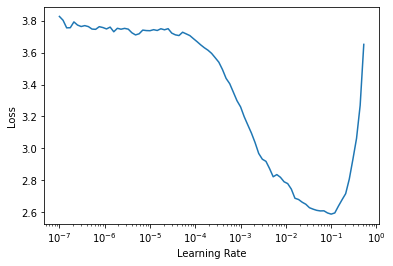

In [ ]:
learn_25.lr_find()

In [ ]:
learn_25.fine_tune(3, base_lr=2e-3, freeze_epochs=5)

That came to around 97% percent(a- identify highly noisy labels and use the predictions from these samples as softtargets) compared to previous version 94%.

## 50 noise percent

In [ ]:
dls_50 = get_dls(df, noice_pct=50, size=224)

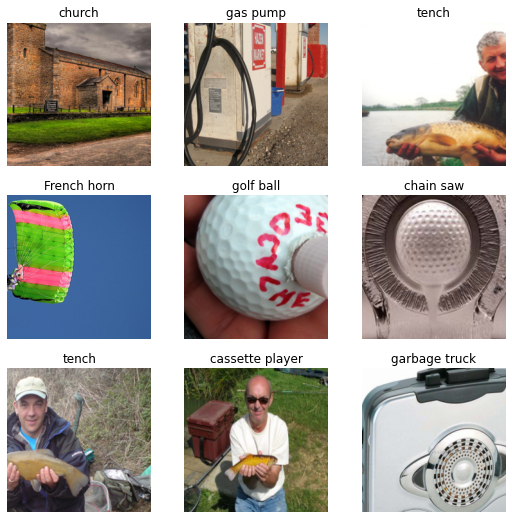

In [ ]:
dls_50.show_batch()

In [ ]:
learn_50 = cnn_learner(dls_50, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0012022644514217973)

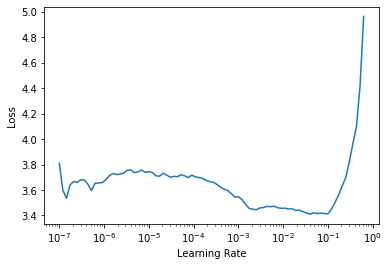

In [ ]:
learn_50.lr_find()

In [ ]:
learn_50.fine_tune(epochs=3, freeze_epochs=5, base_lr=1e-3)

With dataset having 50% incorrect labels present, we still managed to achieve 96% accuracy.

In [ ]:
# Calculate the performance of one batch
# loss_func=CrossEntropyLoss() 
# x, y = dls.train.one_batch()
# preds = learn.model(x)
# learn.loss_func(preds,y)

### LabelSmoothingCrossEntropy

In [ ]:
learn_50 = cnn_learner(dls_50, resnet34, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy()
)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.002511886414140463)

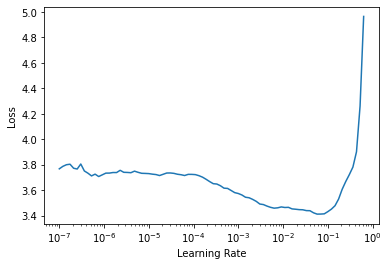

In [ ]:
learn_50.lr_find()

In [ ]:
learn_50.fine_tune(epochs=3, freeze_epochs=5, base_lr=2e-3)

LabelSmoothingCrossEntopy shows equivalent performance.

### Identify noisy labels

In [ ]:
#export
train_preds = learn_50.get_preds(ds_idx=0, with_decoded=True)
from cleanlab.pruning import get_noise_indices
# Cell
# Get the noisy indices
train_ordered_label_errors = get_noise_indices(s=train_preds[1].numpy(), #targets
                             psx=train_preds[0].numpy(),#predictions_prob
                             sorted_index_method='normalized_margin')

In [ ]:
#export
#Get the predictions for the training dataset
preds_50 = np.array(get_inverse_transform(L(list(train_preds[2])).map(dls_50.vocab)));
train_df['predictions'] = preds_50
# Add confidence & confidenceRange
confidence = torch.max(train_preds[0], axis=-1).values
train_df['confidence'] = confidence
train_df['confidenceRange'] = pd.cut(train_df.confidence, bins=[0.0, 0.6, 0.8, 1.0], labels=['<60', '60-80', '80+'])

noisy_train_50 = train_df.loc[train_ordered_label_errors]
df['soft_targets'] = df['noisy_labels_50']
high_confident_noisy = train_df.loc[train_ordered_label_errors][train_df.confidenceRange == '80+'].index

for i, row in df.iterrows():
  if not row['is_valid'] and i in high_confident_noisy:
    pseudo = preds_50[i]
    df.at[i, 'soft_targets'] = pseudo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
del learn_50

In [ ]:
dls_50 = get_dls(df, noice_pct=50, size=224, soft_targets=True)

KeyError: ignored